## anomaly_detection
for all exercises

## Discrete data + probability

#### Techniques for identifying/detecting anomalies
#### Statistical Methods

In [1]:
from __future__ import division

import itertools
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
from numpy import linspace, loadtxt, ones, convolve

import pandas as pd
from datetime import datetime
from dateutil.parser import parse

import math
from sklearn import metrics
from sklearn.ensemble import IsolationForest
from random import randint

from matplotlib import style
import seaborn as sns
%matplotlib inline

import collections

# set default pandas decimal number display format and df display format:
pd.options.display.float_format = '{:20,.2f}'.format
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Wrangle Data

#### Acquire

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8])

In [3]:
new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [4]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
ip                13978 non-null object
timestamp         13978 non-null object
request_method    13978 non-null object
status            13978 non-null int64
size              13978 non-null int64
destination       25 non-null object
request_agent     13978 non-null object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


#### Parse Datetime

In [6]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp = pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')

In [7]:
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:46,97.105.19.58,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:48,97.105.19.58,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [8]:
df['destination'].unique()

array([nan, '"https://python.zach.lol/api/V1/HiZach!"',
       '"https://python.zach.lol/api/v1/stores?page=0"',
       '"https://python.zach.lol/api/v1/stores?page=1"',
       '"https://python.zach.lol/api/v1/stores?page=2"',
       '"https://python.zach.lol/api/v1/stores?page=999"',
       '"https://python.zach.lol/api/v1/items?page=0"',
       '"http://localhost:8889/notebooks/timeseries_acquisition.ipynb"',
       '"https://python.zach.lol/api/v1//api/v1/items?page=2"',
       '"https://python.zach.lol/api/v1//api/v1/items"',
       '"https://python.zach.lol/api/v1//api/v1/items/next_page"',
       '"https://python.zach.lol/api/v1/helloclass!"',
       '"https://python.zach.lol/api/v1/I_DIDNT_DO_IT!!!!"',
       '"http://localhost:8888/notebooks/acquire.ipynb"',
       '"https://python.zach.lol/api/v1/sales?page=3"',
       '"https://ds.codeup.com/8.3_Acquire/"',
       '"https://python.zach.lol/"',
       '"https://python.zach.lol/api/v1/items"',
       '"https://python.zach.lol/a

In [9]:
df.request_method.nunique()

220

#### Clean up text

These two steps below help to "normalize" the data by removing a bunch of distinct but unnecessary items, like the page numbers etc.  This will reduce the MANY distinct items down to a handful of distinct items.  Makes this easier, and REDUCES THE NOISE!

In [10]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

In [11]:
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)
# this finds the "question mark\page=number" and this finds the literal word "page", and then find the equal sign,
# then find a numerical value, and it's repeated a number of times, hence the plus sign.

In [12]:
df.head(10)

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/stores HTTP/1.1,200,1328,NaN,python-requests/2.21.0
2019-04-16 19:34:50,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510753,NaN,python-requests/2.21.0
2019-04-16 19:34:52,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510348,NaN,python-requests/2.21.0
2019-04-16 19:34:52,97.105.19.58,GET / HTTP/1.1,200,42,NaN,python-requests/2.21.0


In [13]:
df.request_method.nunique()

22

#### Add variable: converting bytes to mb

In [14]:
df['size_mb'] = [n/1024/1024 for n in df['size']]
df.describe()

,status,size,size_mb
count,"13,978.00","13,978.00","13,978.00"
mean,200.36,"450,001.91",0.43
std,10.18,"161,491.47",0.15
min,200.00,0.00,0.00
25%,200.00,"500,637.00",0.48
50%,200.00,"510,138.00",0.49
75%,200.00,"511,291.00",0.49
max,499.00,"2,056,327.00",1.96


In [15]:
df.request_method.value_counts(dropna=False)

GET /api/v1/sales HTTP/1.1                      12403
GET /api/v1/items HTTP/1.1                       1065
GET /api/v1/stores HTTP/1.1                       229
GET / HTTP/1.1                                    107
GET /documentation HTTP/1.1                       100
GET /favicon.ico HTTP/1.1                          26
GET /api/v1//api/v1/items HTTP/1.1                 11
GET /api/v1/items/api/v1/items HTTP/1.1             7
GET /api/v1/items/next_page HTTP/1.1                5
GET /api/v1/ HTTP/1.1                               4
GET /api/v1/sales/ HTTP/1.1                         3
GET /api/v1/sales/HTTP/1.1                          3
GET /api/v1/itemsitems HTTP/1.1                     3
GET /api/v1/store HTTP/1.1                          3
GET /api/v1items HTTP/1.1                           2
GET /api/v1 HTTP/1.1                                1
GET /api/v1/helloclass! HTTP/1.1                    1
GET /api/v1/items&page=0 HTTP/1.1                   1
GET /api/v1/I_DIDNT_DO_IT!!!

In [16]:
df.request_method.value_counts(dropna=False)/df.request_method.count()

GET /api/v1/sales HTTP/1.1                                     0.89
GET /api/v1/items HTTP/1.1                                     0.08
GET /api/v1/stores HTTP/1.1                                    0.02
GET / HTTP/1.1                                                 0.01
GET /documentation HTTP/1.1                                    0.01
GET /favicon.ico HTTP/1.1                                      0.00
GET /api/v1//api/v1/items HTTP/1.1                             0.00
GET /api/v1/items/api/v1/items HTTP/1.1                        0.00
GET /api/v1/items/next_page HTTP/1.1                           0.00
GET /api/v1/ HTTP/1.1                                          0.00
GET /api/v1/sales/ HTTP/1.1                                    0.00
GET /api/v1/sales/HTTP/1.1                                     0.00
GET /api/v1/itemsitems HTTP/1.1                                0.00
GET /api/v1/store HTTP/1.1                                     0.00
GET /api/v1items HTTP/1.1                       

In [17]:
df.request_agent.value_counts(dropna=False)/df.request_agent.count()

python-requests/2.21.0                                                                                                                      0.86
python-requests/2.20.1                                                                                                                      0.14
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36                   0.00
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                                          0.00
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                                  0.00
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                                0.00
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36         

### Detecting Anomalies in Discrete Variables
#### Finding anomalies in already existing data
We can see easily some anomalies around various request_agents.

In [18]:
agent_df = pd.DataFrame(df.request_agent.value_counts(dropna=False)).reset_index().\
                       rename(index=str, columns={'index': 'request_agent','request_agent':'agent_count'})

agent_df2 = pd.DataFrame(df.request_agent.value_counts(dropna=False)/df.request_agent.count()).reset_index().\
                       rename(index=str, columns={'index': 'request_agent','request_agent':'agent_proba'})
agent_df = agent_df.merge(agent_df2)

In [19]:
agent_df.shape

(9, 3)

In [20]:
agent_df.head(20)

,request_agent,agent_count,agent_proba
0,python-requests/2.21.0,12005,0.86
1,python-requests/2.20.1,1911,0.14
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34,0.00
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8,0.00
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7,0.00
5,Slackbot 1.0 (+https://api.slack.com/robots),6,0.00
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,4,0.00
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,2,0.00
8,Python-urllib/3.7,1,0.00


In [21]:
# see those where rate < 1% 
agent_df[agent_df.agent_proba < .01]

,request_agent,agent_count,agent_proba
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34,0.00
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8,0.00
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7,0.00
5,Slackbot 1.0 (+https://api.slack.com/robots),6,0.00
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,4,0.00
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,2,0.00
8,Python-urllib/3.7,1,0.00


In [22]:
print('Length of df:')
print(len(agent_df))
print('different distinct request_agents pinging the Zach_lol server.')
print('\n')
print('Tail of df:')
print('... the probabilities of those request_agents pinging that server:')
print('\n')
print(agent_df.tail(10))
print('\n')
print('Combining the first two request_agent probabilities, this means greater than 99.55% of the probability of hitting this server falls into the two types of python requests, 2.21 and 2.20.\n')
print('\n')
print('This means, most anything hitting this server that is NOT a python 2.20 and 2.21 request, is likely an anomaly or an outlier, for good or bad.')


Length of df:
9
different distinct request_agents pinging the Zach_lol server.


Tail of df:
... the probabilities of those request_agents pinging that server:


                                       request_agent  agent_count          agent_proba
0                             python-requests/2.21.0        12005                 0.86
1                             python-requests/2.20.1         1911                 0.14
2  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...           34                 0.00
3  Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...            8                 0.00
4  Slackbot-LinkExpanding 1.0 (+https://api.slack...            7                 0.00
5       Slackbot 1.0 (+https://api.slack.com/robots)            6                 0.00
6  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...            4                 0.00
7  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...            2                 0.00
8                                  Python-urllib/3.7   

### Plotting the request_agent numbers:

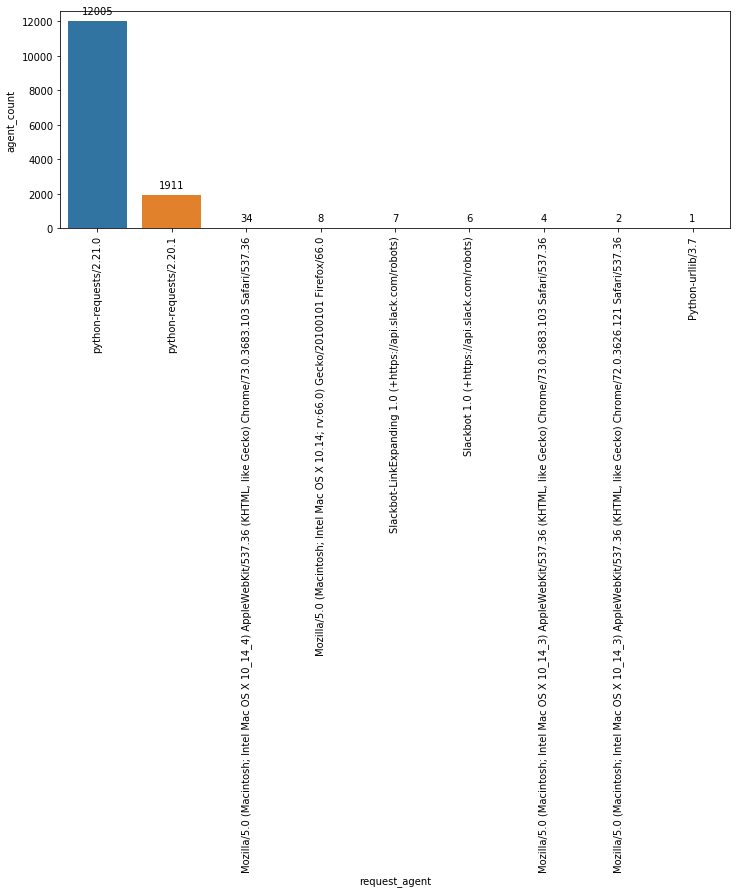

In [23]:
plt.figure(figsize=(12,4))
splot = sns.barplot(data=agent_df, x = 'request_agent', y = 'agent_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

### Detecting anomalies by establishing a baseline and evaluate as new data arrives
#### Establish baseline

In [24]:
df.shape

(13978, 7)

In [25]:
df.columns

Index(['ip', 'request_method', 'status', 'size', 'destination', 'request_agent', 'size_mb'], dtype='object')

In [26]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.49
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.00
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.49
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.49
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.49


In [27]:
train = df['2019-04-16 19:34:42':'2019-04-17 12:55:14'][['ip','request_method','status','size','destination','request_agent','size_mb']]

#### Compute probabilities based on train sample

In [28]:
agent_df = pd.DataFrame(train.request_agent.value_counts(dropna=False)/train.request_agent.count()).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'agent_proba'})

In [29]:
agent_df.head(20)

,request_agent,agent_proba
0,python-requests/2.21.0,0.86
1,python-requests/2.20.1,0.14
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.00
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.00
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.00
5,Slackbot 1.0 (+https://api.slack.com/robots),0.00
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.00
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.00
8,Python-urllib/3.7,0.00


### Merge probabilities with all data (train + new data)
#### Where the ip address is new, i.e. not seen in the training dataset, fill the probability with a value of 0.

In [30]:
df = df.reset_index().merge(agent_df, on=['request_agent'], how='left').fillna(value=0).set_index('timestamp')

In [31]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,agent_proba
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.49,0.86
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.00,0.86
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.49,0.86
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.49,0.86
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.49,0.86


In [32]:
df.agent_proba.value_counts()

0.86    12005
0.14     1911
0.00       34
0.00        8
0.00        7
0.00        6
0.00        4
0.00        2
0.00        1
Name: agent_proba, dtype: int64

### Conditional Probabilities: probabilities using 2 discrete variables
#### Probability of destination given request_agent:
If we are looking for an unexpected destination (like weird website, etc) from a known/common request agent.

In [33]:
train.groupby('request_agent').size()
# this is the count by request_agent

request_agent
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                               8
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36        2
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36        4
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36       34
Python-urllib/3.7                                                                                                                1
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                     6
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                       7
python-requests/2.20.1                                               

In [34]:
train.groupby('request_agent').size().div(len(df))
# this is the probability of the distinct request_agent items by the total data frame

request_agent
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                                          0.00
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36                   0.00
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36                   0.00
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36                   0.00
Python-urllib/3.7                                                                                                                           0.00
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                                0.00
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                          

In [35]:
# now dividing the size, above, by the length of the df
# This is a repeat of the above cell, except setting a new data frame with these items and probs:
request_probs = train.groupby('request_agent').size().div(len(df))
request_probs

request_agent
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                                          0.00
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36                   0.00
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36                   0.00
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36                   0.00
Python-urllib/3.7                                                                                                                           0.00
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                                0.00
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                          

In [36]:
destination_given_agent = pd.DataFrame(train.groupby(['request_agent', 'destination']).\
                               size().div(len(train)).\
                               div(request_probs, 
                                   axis=0, 
                                   level='request_agent').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_destination_given_agent'})
                              )

In [37]:
destination_given_agent.head(40)

,request_agent,destination,proba_destination_given_agent
0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,https://python.zach.lol/,0.50
1,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,https://ds.codeup.com/8.3_Acquire/,0.50
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,https://python.zach.lol/,0.50
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,http://localhost:8888/notebooks/acquire.ipynb,0.03
4,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,http://localhost:8889/notebooks/timeseries_acq...,0.03
5,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,https://ds.codeup.com/8.3_Acquire/,0.03
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,https://python.zach.lol/,0.03
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,https://python.zach.lol/api/V1/HiZach!,0.03
8,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,https://python.zach.lol/api/v1/,0.06
9,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,https://python.zach.lol/api/v1//api/v1/items,0.03


In [38]:
agent_destination_count = pd.DataFrame(train.groupby(['request_agent', 'destination'])['request_method'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_method': 'agent_destination_count'}))

In [39]:
agent_destination_count.agent_destination_count.nunique()

2

In [40]:
df.request_method.unique()

array(['GET /api/v1/sales HTTP/1.1', 'GET /api/v1/items HTTP/1.1',
       'GET /api/v1/stores HTTP/1.1', 'GET / HTTP/1.1',
       'GET /documentation HTTP/1.1', 'GET /api/V1/HiZach! HTTP/1.1',
       'GET /favicon.ico HTTP/1.1',
       'GET /api/v1/items/next_page HTTP/1.1', 'GET /api/v1/ HTTP/1.1',
       'GET /api/v1//api/v1/items HTTP/1.1',
       'GET /api/v1//api/v1/items/next_page HTTP/1.1',
       'GET /api/v1items HTTP/1.1', 'GET /api/v1 HTTP/1.1',
       'GET /api/v1/items/api/v1/items HTTP/1.1',
       'GET /api/v1/helloclass! HTTP/1.1',
       'GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1',
       'GET /api/v1/itemsitems HTTP/1.1',
       'GET /api/v1/items&page=0 HTTP/1.1', 'GET /api/v1/sales/ HTTP/1.1',
       'GET /api/v1/store HTTP/1.1', 'GET /api/v1/items/HTTP/1.1',
       'GET /api/v1/sales/HTTP/1.1'], dtype=object)

In [41]:
agent_destination = destination_given_agent.merge(agent_destination_count)

In [42]:
agent_destination.head()

,request_agent,destination,proba_destination_given_agent,agent_destination_count
0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,https://python.zach.lol/,0.50,1
1,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,https://ds.codeup.com/8.3_Acquire/,0.50,2
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,https://python.zach.lol/,0.50,2
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,http://localhost:8888/notebooks/acquire.ipynb,0.03,1
4,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,http://localhost:8889/notebooks/timeseries_acq...,0.03,1


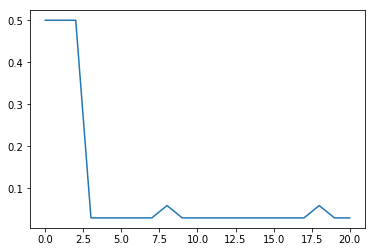

In [43]:
plt.plot(agent_destination.proba_destination_given_agent)

### Add these probabilities to original events to detect anomalous events

In [44]:
df = df.reset_index().merge(agent_destination, on=['request_agent', 'destination'], how='left').fillna(value=0).set_index('timestamp')

In [45]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,agent_proba,proba_destination_given_agent,agent_destination_count
timestamp,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.49,0.86,0.00,0.00
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.00,0.86,0.00,0.00
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.49,0.86,0.00,0.00
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.49,0.86,0.00,0.00
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.49,0.86,0.00,0.00


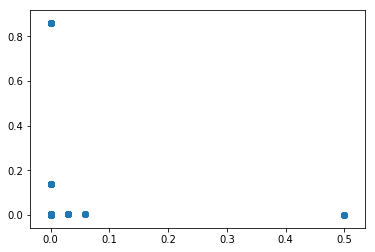

In [46]:
plt.scatter(df.proba_destination_given_agent, df.agent_proba)

## Time series + EMA

Discover users who are accessing our curriculum pages way beyond the end of their codeup time.
- What would the dataframe look like?
- Use time series method for detecting anomalies, like exponential moving average with %b.
- See (paper) notes for good details on how to do this, to include graphics and images, as well as the previous lesson:
- ("anomaly_detection_lesson_29Apr19_timeseries_anomalies.ipynb" in same folder)

## Review Maggie's walkthrough here... it calculates number of distinct users w/page view per day per cohort.

#### she calculates the following:
over 7 days

for each cohort per day:
- EMA
- upper bound (ub)
- lower bound (lb)
- actual value
- % bound

(current - lb) / divided by / (ub - lb)

#### Bringing in data from csv

In [79]:
colnames=['date', 'page_viewed', 'user_id', 'cohort', 'ip']
df_orig = pd.read_csv('/Users/rachelreuter/ds-methodologies/anomaly_detection/anonymized-curriculum-access.txt',
    header=None,
    index_col=False,
    names=colnames,
    sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
    na_values='"-"',
    usecols=[0,2,3,4,5]
)

In [80]:
df_orig = df_orig.dropna()
df_orig.cohort = df_orig.cohort.astype('int')
print(df_orig.info())
df_orig.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219070 entries, 0 to 233527
Data columns (total 5 columns):
date           219070 non-null object
page_viewed    219070 non-null object
user_id        219070 non-null int64
cohort         219070 non-null int64
ip             219070 non-null object
dtypes: int64(2), object(3)
memory usage: 10.0+ MB
None


,date,page_viewed,user_id,cohort,ip
0,2018-01-26,/,1,8,97.105.19.61
1,2018-01-26,java-ii,1,8,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22,97.105.19.61


In [93]:
colnames=['cohort_name','cohort']
df_cohort = pd.read_csv('cohort_id_name.txt',
                       names=colnames, 
                       skiprows=1)
print(df_cohort.info())
df_cohort.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 2 columns):
cohort_name    31 non-null object
cohort         31 non-null int64
dtypes: int64(1), object(1)
memory usage: 576.0+ bytes
None


,cohort_name,cohort
0,Arches,1
1,Badlands,2
2,Carlsbad,3
3,Denali,4
4,Everglades,5


In [94]:
df = df_orig.merge(df_cohort, on='cohort', how='left')
df.head()

,date,page_viewed,user_id,cohort,ip,cohort_name
0,2018-01-26,/,1,8,97.105.19.61,Hampton
1,2018-01-26,java-ii,1,8,97.105.19.61,Hampton
2,2018-01-26,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton
3,2018-01-26,slides/object_oriented_programming,1,8,97.105.19.61,Hampton
4,2018-01-26,javascript-i/conditionals,2,22,97.105.19.61,Teddy


#### Looking at shape, columns, dtypes and description of data

In [95]:
df.shape

(219070, 6)

In [96]:
df.columns

Index(['date', 'page_viewed', 'user_id', 'cohort', 'ip', 'cohort_name'], dtype='object')

In [84]:
#df_orig.dtypes

In [97]:
df.describe()

,user_id,cohort
count,"219,070.00","219,070.00"
mean,185.75,23.12
std,107.37,5.87
min,1.00,1.00
25%,105.00,22.00
50%,199.00,24.00
75%,272.00,26.00
max,398.00,31.00


#### Combining date and time into one field

In [70]:
# df_orig['dateandtime'] = df_orig['date'] + ' ' + df_orig['time']

In [71]:
# df_orig.head()

- Success

#### Changing that new combined dateandtime field to datetime format

In [98]:
df['date'] = pd.to_datetime(df.date)
df = df.dropna()

In [72]:
# df_orig['dateandtime'] = pd.to_datetime(df_orig['dateandtime'])

In [87]:
#df_orig['date'] = pd.to_datetime(df_orig['date'])

In [103]:
df.dtypes

date           datetime64[ns]
page_viewed            object
user_id                 int64
cohort                  int64
ip                     object
cohort_name            object
dtype: object

In [104]:
df.shape

(219070, 6)

- Success

#### Checking the dataframe for blanks, nulls, missing, Nan, etc

In [105]:
def missing_values_col(df):
	"""
	Write or use a previously written function to return the
	total missing values and the percent missing values by column.
	"""
	null_count = df.isnull().sum()
	null_percentage = (null_count / df.shape[0]) * 100
	empty_count = pd.Series(((df == ' ') | (df == '')).sum())
	empty_percentage = (empty_count / df.shape[0]) * 100
	nan_count = pd.Series(((df == 'nan') | (df == 'NaN')).sum())
	nan_percentage = (nan_count / df.shape[0]) * 100
	return pd.DataFrame({'num_missing': null_count, 'missing_percentage': null_percentage,
	                     'num_empty': empty_count, 'empty_percentage': empty_percentage,
	                     'nan_count': nan_count, 'nan_percentage': nan_percentage})

In [108]:
missing_values_col(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
date,0,0.00,0,0.00,0,0.00
page_viewed,0,0.00,0,0.00,0,0.00
user_id,0,0.00,0,0.00,0,0.00
cohort,0,0.00,0,0.00,0,0.00
ip,0,0.00,0,0.00,0,0.00
cohort_name,0,0.00,0,0.00,0,0.00


In [107]:
def peekatdata(df):
    print("\n \n SHAPE:")
    print(df.shape)

    print("\n \n COLS:")
    print(df.columns)

    print("\n \n INFO:")
    print(df.info())

    print("\n \n Missing Values:")
    missing_vals = df.columns[df.isnull().any()]
    print(df.isnull().sum())

    print("\n \n DESCRIBE:")
    print(df.describe())

    print('\n \n HEAD:')
    print(df.head(5))

    print('\n \n TAIL:' )
    print(df.tail(5))

In [109]:
peekatdata(df)


 
 SHAPE:
(219070, 6)

 
 COLS:
Index(['date', 'page_viewed', 'user_id', 'cohort', 'ip', 'cohort_name'], dtype='object')

 
 INFO:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 219070 entries, 0 to 219069
Data columns (total 6 columns):
date           219070 non-null datetime64[ns]
page_viewed    219070 non-null object
user_id        219070 non-null int64
cohort         219070 non-null int64
ip             219070 non-null object
cohort_name    219070 non-null object
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 11.7+ MB
None

 
 Missing Values:
date           0
page_viewed    0
user_id        0
cohort         0
ip             0
cohort_name    0
dtype: int64

 
 DESCRIBE:
                   user_id               cohort
count           219,070.00           219,070.00
mean                185.75                23.12
std                 107.37                 5.87
min                   1.00                 1.00
25%                 105.00                22.00
50%         

#### Filling in any Nans with zero

In [ ]:
#df_orig = df_orig.fillna(0)

In [ ]:
#df_orig[['cohort']] = df_orig[['cohort']].astype(int)

In [ ]:
#df_orig[['cohort']] = df_orig[['cohort']].astype(str)

In [ ]:
#df_orig[['student_id']] = df_orig[['student_id']].astype(str)

In [ ]:
# df_orig = field_drop(df_orig)

In [ ]:
#df_orig = df_orig[['date','dateandtime','ip','cohort','student_id','curriculum_topic']]

##### Dataframe now appears to be ready to review.  Will check with .describe.

In [112]:
df.describe(include='all')

,date,page_viewed,user_id,cohort,ip,cohort_name
count,219070,219070,"219,070.00","219,070.00",219070,219070
unique,432,964,nan,nan,1605,26
top,2018-08-17 00:00:00,/,nan,nan,97.105.19.58,Voyageurs
freq,1760,10862,nan,nan,97764,34485
first,2018-01-26 00:00:00,NaN,nan,nan,NaN,NaN
last,2019-04-02 00:00:00,NaN,nan,nan,NaN,NaN
mean,NaN,NaN,185.75,23.12,NaN,NaN
std,NaN,NaN,107.37,5.87,NaN,NaN
min,NaN,NaN,1.00,1.00,NaN,NaN
25%,NaN,NaN,105.00,22.00,NaN,NaN


#### Dataframe is prepared and ready to proceed with the anomaly detection lesson.

#### Reiterate the lesson objective:

Discover users who are accessing our curriculum pages way beyond the end of their codeup time.
- What would the dataframe look like?
- Use time series method for detecting anomalies, like exponential moving average with %b.
- See (paper) notes for good details on how to do this, to include graphics and images, as well as the previous lesson:
- ("anomaly_detection_lesson_29Apr19_timeseries_anomalies.ipynb" in same folder)

In [113]:
df_agg = df.groupby(['date','cohort','cohort_name'])['user_id'].\
nunique().\
reset_index().\
rename(index=str, columns={'user_id': 'users_viewed'})


# df_agg = df.groupby(['date','cohort_id','cohort_name'])['user_id'].\
#                         nunique().\
#                     reset_index().\
#                     rename(index=str, 
#                        columns={'user_id': 'users_viewed'})

In [128]:
df_agg.tail()

,date,cohort,cohort_name,users_viewed
3361,2019-04-02,26,Xanadu,2
3362,2019-04-02,27,Yosemite,2
3363,2019-04-02,28,Staff,5
3364,2019-04-02,29,Zion,22
3365,2019-04-02,31,Andromeda,20


In [123]:
df_agg.shape

(3366, 4)

In [121]:
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3366 entries, 0 to 3365
Data columns (total 4 columns):
date            3366 non-null datetime64[ns]
cohort          3366 non-null int64
cohort_name     3366 non-null object
users_viewed    3366 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 131.5+ KB


### EMA

In [119]:
cohorts = list(df_agg.cohort_name.unique())
cohorts

['Arches',
 'Hampton',
 'Kings',
 'Niagara',
 'Pinnacles',
 'Quincy',
 'Sequoia',
 'Teddy',
 'Lassen',
 'Mammoth',
 'Glacier',
 'Denali',
 'Joshua',
 'Olympic',
 'Ulysses',
 'Badlands',
 'Apollo',
 'Ike',
 'Voyageurs',
 'Wrangell',
 'Xanadu',
 'Franklin',
 'Yosemite',
 'Staff',
 'Zion',
 'Andromeda']

#### Set the index to date

In [125]:
df = df_agg.set_index('date').\
rename(index=str, columns={'users_viewed':'ema'}).\
drop(columns='cohort')

# df = df_agg.set_index('date').\
#             rename(index=str, columns={'users_viewed':'ema'}).\
#             drop(columns='cohort_id')

In [126]:
df.head()

,cohort_name,ema
date,,
2018-01-26 00:00:00,Arches,1
2018-01-26 00:00:00,Hampton,1
2018-01-26 00:00:00,Kings,1
2018-01-26 00:00:00,Niagara,2
2018-01-26 00:00:00,Pinnacles,1


In [132]:
def bollinger_bands(df):
    ema = df.ewm(span=14, adjust=False).mean()
    ema['stdev'] = ema.ema.rolling(14).std()
    ema['ub'] = ema.ema + ema.stdev * 3
    ema['lb'] = ema.ema - ema.stdev * 3
    return ema.reset_index()

In [133]:
bands = []
for cohort in cohorts:
    bb = bollinger_bands(df[df.cohort_name == cohort])
    bands.append(bb)

df2 = pd.concat(bands)

# bands = []
# for cohort in cohorts:
#     bb = bollinger_bands(df[df.cohort_name == cohort])
#     bands.append(bb)

# df2 = pd.concat(bands)

In [138]:
df2.head()

,date,cohort_name,ema,stdev,ub,lb
0,2018-01-26 00:00:00,Arches,1.00,nan,nan,nan
1,2018-01-29 00:00:00,Arches,1.27,nan,nan,nan
2,2018-01-30 00:00:00,Arches,1.36,nan,nan,nan
3,2018-01-31 00:00:00,Arches,1.45,nan,nan,nan
4,2018-02-01 00:00:00,Arches,1.39,nan,nan,nan


In [ ]:
def bollinger_bands(df):
    ema = df.ewm(span=14, adjust=False).mean()
    ema['stdev'] = ema.ema.rolling(14).std()
    ema['ub'] = ema.ema + ema.stdev*3
    ema['lb'] = ema.ema - ema.stdev*3
    return ema.reset_index()

In [139]:
df2.isnull().sum()

date             0
cohort_name      0
ema              0
stdev          298
ub             298
lb             298
dtype: int64

In [142]:
df_missing = df2[df2.stdev.isnull()][['cohort_name','ema']]
df_missing.head()

,cohort_name,ema
0,Arches,1.00
1,Arches,1.27
2,Arches,1.36
3,Arches,1.45
4,Arches,1.39


### Just pick one cohort to do the grouping on, and then do the timeseries on that one grouped cohort.

In [ ]:
df = df_orig[df_orig.cohort == '0']

In [ ]:
df.shape

In [ ]:
df.describe(include='all')

In [ ]:
peekatdata(df)

In [ ]:
df['student_id'].unique()

In [ ]:
df.dtypes

In [ ]:
df['student_id'].max()

In [ ]:
df.head(10)

In [ ]:
def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()  

#### Resample to 30 minute intervals taking min of curriculum page visited

In [ ]:
monkey = df.groupby([df.index.date,'student_id']).count()

In [ ]:
monkey

In [ ]:
monkey2 = df['student_id'].resample('1D').count()

In [ ]:
df.groupby('student_id').size()

In [ ]:
monkey2

In [ ]:
df.groupby('curriculum_topic').describe()

In [ ]:
df.groupby(df.index.date).agg(['min','max','mean'])

In [ ]:
#df = df['curriculum_topic'].resample('30T').min()
df2 = df['curriculum_topic'].resample('30T').value_counts.min()

In [ ]:
df2

In [ ]:
idx = pd.date_range(
    df2.sort_index().index.min(), 
    df2.sort_index().index.max(),
    freq='30min'
)

In [ ]:
df2 = df2.reindex(idx, fill_value=0).fillna(value=0)

In [ ]:
df2

### This is preparing the data so we can look at the avg, SMA, EMA and %B.


In [ ]:
start_date_train = df2.head(1).index[0]

In [ ]:
end_date_train = '2019-03-15 23:30:00'

In [ ]:
start_date_test = '2019-03-16 00:00:00'

In [ ]:
train = df2[:end_date_train]
test = df2[start_date_test:]

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train)
plt.plot(test)
plt.show()

In [ ]:
# calculating upper and lower bands, Maggie provided in the slack channel:

span = 24
ema_long = train.ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*3
lb = midband - ema_long[-24:-1].std()*3

yhat['moving_avg_forecast'] = midband